# **Access the  Kaggle COVID-19 Challenge Datasets**

### Prior to running code you must create Kaggle account, go to  
### "Settings" and create an API. This will prompt you to download Kaggle.json



In [ ]:
# Upload your kaggle.json file using the following snippet in a code cell:
from google.colab import files
files.upload()

# Install the kaggle API
!pip install -q kaggle

# Move the kaggle.json file into ~/.kaggle, which is where the API client
# expects your token to be located:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Access Kaggle Datasets
!kaggle datasets list

# Download COVID-19 Datasets
!kaggle datasets download -d kimjihoo/coronavirusdataset/data-science-for-COVID-19-(DS4C)
#!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset

# Unzip dataset files
!unzip /content/novel-corona-virus-2019-dataset.zip

Saving kaggle.json to kaggle (1).json
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-04-25 00:03:33          58857  
divyansh22/us-border-crossing-data                          US Border Crossing Data                               2MB  2020-04-19 09:38:10            236  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           5898  
baltacifatih/turkish-lira-banknote-dataset                  Turkish Lira Banknote Dataset                         3GB  2020-04-19 14:48:39             20  
doaaalsenani/usa-cers-data

In [ ]:
import pandas as pd
import numpy as np

US_deaths = pd.read_csv('time_series_covid_19_deaths_US.csv')

US_deaths = US_deaths.iloc[:,12:len(US_deaths)]
#US_deaths

US_cases = pd.read_csv('time_series_covid_19_confirmed_US.csv')
US_cases = US_deaths.iloc[:,0:len(US_cases)]
print(np.size(US_deaths))
print(np.size(US_cases))


319676
319676


In [ ]:
#from google.colab import files
#files.upload()

# Unzip dataset files
!unzip /content/covid-tracking-data-master.zip
#https://github.com/COVID19Tracking/covid-tracking-data/blob/master/data/us_daily.csv

Archive:  /content/covid-tracking-data-master.zip
d24f43f7e199e932d3f0c38be96a025821a7411a
   creating: covid-tracking-data-master/
   creating: covid-tracking-data-master/.github/
   creating: covid-tracking-data-master/.github/workflows/
  inflating: covid-tracking-data-master/.github/workflows/update.yml  
  inflating: covid-tracking-data-master/.gitignore  
  inflating: covid-tracking-data-master/LICENSE  
  inflating: covid-tracking-data-master/README.md  
  inflating: covid-tracking-data-master/backup_to_s3.py  
   creating: covid-tracking-data-master/data/
  inflating: covid-tracking-data-master/data/counties.csv  
  inflating: covid-tracking-data-master/data/states_current.csv  
  inflating: covid-tracking-data-master/data/states_daily_4pm_et.csv  
  inflating: covid-tracking-data-master/data/states_info.csv  
  inflating: covid-tracking-data-master/data/us_current.csv  
  inflating: covid-tracking-data-master/data/us_daily.csv  
  inflating: covid-tracking-data-master/environm

## **Multivariate Time Step LSTM for COVID-19 Prediction**

In [ ]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD

# convert series to supervised learning
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	#if dropnan:
		#agg.dropna(inplace=True)
	return agg

# load dataset
#data = pd.read_csv('/content/covid-tracking-data-master/data/us_daily.csv')
data = pd.read_csv('/content/us_daily.csv')
idx = data.iloc[1:,0]

# concatenate dataset
dataset = pd.DataFrame(data)
values = np.reshape(dataset, (-1,4))
# integer encode direction
#encoder = LabelEncoder()
#values.iloc[:,2]= encoder.fit_transform(values.iloc[:,2])
# ensure all data is float
values = values.astype('float32')
print(values)

     Positive    Deaths  Hospitalizations      Total
0         1.0       0.0               0.0        1.0
1         1.0       0.0               0.0        1.0
2         1.0       0.0               0.0        1.0
3         1.0       0.0               0.0        1.0
4         1.0       0.0               0.0        1.0
..        ...       ...               ...        ...
94   932242.0  112783.0           48069.0  5201964.0
95   959258.0  116801.0           49164.0  5407497.0
96   981134.0  121609.0           50327.0  5597572.0
97  1005592.0  139342.0           52525.0  5799934.0
98  1033157.0  147484.0           55225.0  6031002.0

[99 rows x 4 columns]


In [ ]:
import copy

valuesOrig = copy.deepcopy(values)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag days
n_days = 2
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
#print(reframed.values)

# split into train and test sets
values = reframed.values
values = scaled[1:,:] #Gets rid of Headers
print(values.shape)
n_train_hours = int(80)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(train.shape)
print(test.shape)
print(train)

(98, 4)
(80, 4)
(18, 4)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.67908022e-07 0.00000000e+00

In [ ]:
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X)
print(train_y)

(80, 4) (80,) (18, 4) (18,)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.67908022e-07 0.00000000

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((int(train_X.shape[0]/n_days), n_days, n_features))
train_y = train_y.reshape(int(train_y.shape[0]/n_days), n_days)
test_X = test_X.reshape((int(test_X.shape[0]/n_days), n_days, n_features))
test_y = test_y.reshape(int(test_y.shape[0]/n_days), n_days)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(test_X)

(40, 2, 4) (40, 2) (9, 2, 4) (9, 2)
[[[0.5341933  0.23155732 0.40266183 0.47400752]
  [0.558361   0.24031082 0.4301313  0.4961818 ]]

 [[0.5833262  0.26678827 0.4719964  0.52103204]
  [0.6127932  0.29509643 0.5172295  0.54376775]]

 [[0.6428148  0.3318665  0.556306   0.57065415]
  [0.6734317  0.3637276  0.5936623  0.5958377 ]]

 [[0.70054764 0.42690057 0.62574923 0.619272  ]
  [0.7271758  0.45658514 0.6559348  0.6471075 ]]

 [[0.7515012  0.4721597  0.6865188  0.6703582 ]
  [0.7765807  0.4949825  0.7328384  0.6948977 ]]

 [[0.80357856 0.53043044 0.7697239  0.7470312 ]
  [0.8341306  0.5573079  0.80371207 0.7788798 ]]

 [[0.86754084 0.6883255  0.8375011  0.8174079 ]
  [0.90232354 0.76471347 0.870421   0.8625372 ]]

 [[0.9284726  0.79195714 0.890249   0.89661664]
  [0.94964653 0.82455724 0.9113083  0.92813295]]

 [[0.9733196  0.94479406 0.9511091  0.9616866 ]
  [1.         1.         1.         0.99999994]]]


In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['accuracy'], optimizer='adam')
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# save model to single file
#model.save('filename.h5')
# plot history
pyplot.title('Train and Test Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()
# plot accuracy
pyplot.title('Model Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.legend()
pyplot.show()

ValueError: ignored

In [ ]:
# make a prediction in comparison to test data
yhat = model.predict(test_X)
# reshape test_X back to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
print(yhat) #Needs to be inverse scaled back to original format to make sense

[[0.5141188 ]
 [0.5415613 ]
 [0.5652679 ]
 [0.59344566]
 [0.62275946]
 [0.6540042 ]
 [0.6836314 ]
 [0.71329397]
 [0.7405901 ]
 [0.763403  ]
 [0.78819156]
 [0.8248308 ]
 [0.853511  ]
 [0.89298505]
 [0.93018985]
 [0.9555236 ]
 [0.977964  ]
 [1.0067236 ]
 [1.0340436 ]]
[[0.505912   0.21447073 0.37457675 0.45052984]
 [0.5341933  0.23155732 0.40266183 0.47400752]
 [0.558361   0.24031082 0.4301313  0.4961818 ]
 [0.5833262  0.26678827 0.4719964  0.52103204]
 [0.6127932  0.29509643 0.5172295  0.54376775]
 [0.6428148  0.3318665  0.556306   0.57065415]
 [0.6734317  0.3637276  0.5936623  0.5958377 ]
 [0.70054764 0.42690057 0.62574923 0.619272  ]
 [0.7271758  0.45658514 0.6559348  0.6471075 ]
 [0.7515012  0.4721597  0.6865188  0.6703582 ]
 [0.7765807  0.4949825  0.7328384  0.6948977 ]
 [0.80357856 0.53043044 0.7697239  0.7470312 ]
 [0.8341306  0.5573079  0.80371207 0.7788798 ]
 [0.86754084 0.6883255  0.8375011  0.8174079 ]
 [0.90232354 0.76471347 0.870421   0.8625372 ]
 [0.9284726  0.79195714 0.89

In [ ]:
import statistics as stat
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print('Inverse scale of forecast data')
print(inv_yhat)
inv_yhat = inv_yhat[:,0] #column to be predicted output
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
print('Inverse scale of actual')
print(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
scaled_err = stat.mean(abs(inv_y-inv_yhat)/inv_y * 100)
print('Test Percentage Error: %.3f' % scaled_err)
print(inv_yhat)
print(inv_y)

Inverse scale of forecast data
[[ 531165.94    31631.      20686.    2717147.   ]
 [ 559518.3     34151.      22237.    2858741.   ]
 [ 584010.94    35442.      23754.    2992474.   ]
 [ 613122.94    39347.      26066.    3142345.8  ]
 [ 643408.7     43522.      28563.998 3279465.   ]
 [ 675689.4     48945.      30721.998 3441617.   ]
 [ 706298.9     53644.      32785.    3593499.   ]
 [ 736944.94    62961.      34557.    3734831.2  ]
 [ 765146.1     67339.      36224.    3902707.   ]
 [ 788715.4     69636.      37913.    4042932.   ]
 [ 814325.8     73002.      40471.    4190930.   ]
 [ 852179.9     78230.      42508.    4505347.   ]
 [ 881811.      82194.      44385.    4697426.   ]
 [ 922593.9    101517.      46251.    4929789.   ]
 [ 961032.25   112783.      48069.    5201964.   ]
 [ 987205.94   116801.      49164.    5407497.   ]
 [1010390.4    121609.      50327.    5597572.   ]
 [1040103.56   139342.      52525.    5799934.   ]
 [1068329.2    147484.      55225.    6031002.   ]]

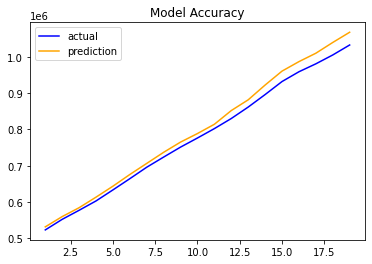

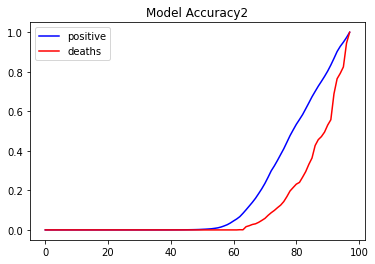

In [ ]:
pyplot.title('Model Accuracy')
time = np.arange(1,20)
time = time.reshape(19,)
pyplot.plot(time, inv_y, color='blue', label='actual')
pyplot.plot(time, inv_yhat, color='orange', label='prediction')
pyplot.legend()
pyplot.show()

pyplot.title('Model Accuracy2')
time = np.arange(98)
actual = values
prediction = [train_y, inv_yhat]
pyplot.plot(time, actual[:,0], color='blue', label='positive')
pyplot.plot(time, actual[:,1], color='red', label='deaths')
# pyplot.plot(time, prediction, color='orange', label='prediction')
pyplot.legend()
pyplot.show()

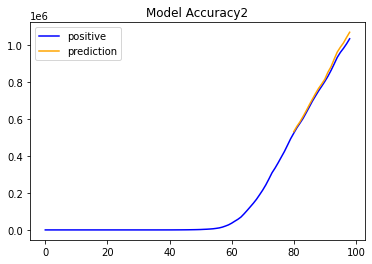

In [ ]:
pyplot.title('Model Accuracy2')
time = np.arange(99)
actual = valuesOrig # from deepcopy
prediction = [train_y, inv_yhat]
pyplot.plot(time, actual.iloc[:,0], color='blue', label='positive')
# pyplot.plot(time, actual.iloc[:,1], color='red', label='deaths')
# pyplot.plot(time, actual.iloc[:,2], color='orange', label='Hospitalized')
# pyplot.plot(time, actual.iloc[:,3], color='black', label='total')
# pyplot.plot(time, prediction, color='orange', label='prediction')
time2 = np.arange(80, 99) # match the last days of the data
pyplot.plot(time2, inv_yhat, color='orange', label='prediction')
pyplot.legend()
pyplot.show()